In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("./utils")
from utils.pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
la=xr.open_dataset('./utils/sparsegrid_landarea.nc').landarea
inits={'AD':1710,'SASU':1730,'postSASU':1810,'HIST':1850}
monthly={'AD':False,'SASU':False,'postSASU':False,'HIST':True}

In [5]:
def preprocess(ds):
    dvs=['TLAI','TWS','GPP','NPP','TOTVEGC','TOTSOMC','TOTECOSYSC']
    return ds[dvs]

In [6]:
def get_files(case,keys=[],id='oaat'):
    if not keys:
        if case=='postSASU':
            s='/glade/derecho/scratch/djk2120/postp/ppe/ctsm5.3.0/postsasu/'
            c='*'
        else:
            s='/glade/derecho/scratch/linnia/'
            if case=='HIST':
                c='ctsm5.3.0_transient_'+id+'*'
            else:
                c='ctsm5.3.0_transient_'+case+'_'+id+'*'
        keys=[d.split('_')[-1].split('.')[0] for d in sorted(glob.glob(s+c))]
    files=[]
    nfiles=0
    goodkeys=[]
    for k in keys:
        if case=='postSASU':
            m='*'
        else:
            m='/run/*.h0.*'
        if case=='HIST':
            c='ctsm5.3.0_transient_'+k
        else:
            c='ctsm5.3.0_transient_'+case+'_'+k
        d=s+c
        f=sorted(glob.glob(d+m))
        if not nfiles:
            nfiles=len(f)
        if len(f)==nfiles:
            files.append(f)
            goodkeys.append(k)
        else:
            print(case,k,len(f),'files')
    return files,goodkeys
        
        

In [7]:
def get_case(case,inits,monthly):
    files,keys=get_files(case)

    
    ds=xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                     preprocess=preprocess,decode_times=False,parallel=True)
    ds['ens']=keys

    if monthly[case]:
        ds['time']=xr.cftime_range(str(inits[case]),periods=len(ds.time),freq='MS',calendar='noleap')
        #ds=xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})
    else:
        ds=ds.isel(time=range(1,len(ds.time)))
        ds['year']=xr.DataArray(range(inits[case],inits[case]+len(ds.time)),dims='time')
        ds=ds.swap_dims({'time':'year'})
        
    return ds

In [14]:
files,keys=get_files('postSASU')

In [8]:
cases=['SASU','postSASU']
dsets={c:get_case(c,inits,monthly) for c in cases}

SASU oaat0081 0 files
SASU oaat0087 0 files
SASU oaat0175 1 files
SASU oaat0176 0 files
SASU oaat0177 0 files
SASU oaat0178 0 files
SASU oaat0179 0 files
SASU oaat0180 0 files
SASU oaat0181 0 files
SASU oaat0182 0 files
SASU oaat0183 0 files
SASU oaat0184 0 files
SASU oaat0185 1 files
SASU oaat0186 1 files
SASU oaat0187 1 files
SASU oaat0188 1 files
SASU oaat0189 1 files
SASU oaat0190 1 files
SASU oaat0191 1 files
SASU oaat0192 1 files
SASU oaat0193 1 files
SASU oaat0194 1 files
SASU oaat0195 1 files
SASU oaat0196 1 files
SASU oaat0197 1 files


In [ ]:
#cf=24*60*60*365*1e-9*la.sum()
cf=24*60*60*365*1e-9*la.sum()
#gpp_AD=cf*gmean(dsets['AD'].GPP,la)
tec_SASU=cf*gmean(dsets['SASU'].TOTECOSYSC,la)
tec_pSASU=cf*gmean(dsets['postSASU'].TOTECOSYSC,la)

In [9]:
lai_pSASU=gmean(dsets['postSASU'].TLAI,la)

In [40]:
# check b4b
arr = lai_pSASU.isel(year=39).values
unique_elements, counts = np.unique(arr, return_counts=True)
duplicates = unique_elements[counts > 1]
duplicate_indices = [np.where(arr == elem)[0] for elem in duplicates]

In [20]:
dsets['postSASU']

<xarray.Dataset>
Dimensions:     (year: 40, ens: 143, gridcell: 400)
Coordinates:
    time        (year) int64 2000 2001 2002 2003 2004 ... 2036 2037 2038 2039
  * year        (year) int64 1810 1811 1812 1813 1814 ... 1846 1847 1848 1849
  * ens         (ens) <U8 'oaat0000' 'oaat0001' ... 'oaat0143' 'oaat0144'
Dimensions without coordinates: gridcell
Data variables:
    TLAI        (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    TWS         (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    GPP         (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    NPP         (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    TOTVEGC     (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    TOTSOMC     (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>
    TOTECOSYSC  (ens, gridcell, year) float64 dask.array<chunksize=(1, 400, 40), meta=np.ndarray>

In [15]:
da = dsets['SASU'].TLAI.isel(ens=52).isel(year=79)
SASUy80_map =get_map(da)

In [14]:
da = dsets['postSASU'].TLAI.isel(ens=52).isel(year=0)
pSASUy0_map =get_map(da)

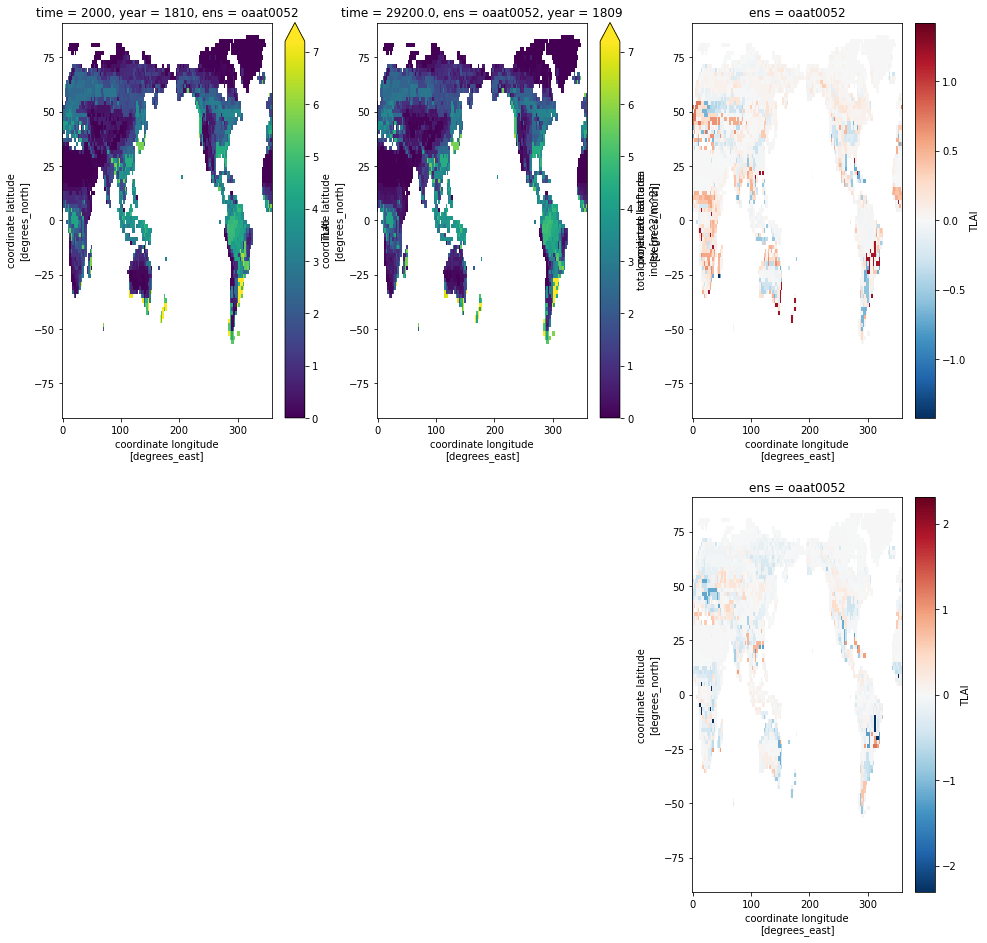

In [23]:
plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
pSASUy0_map.plot(vmax=7.2)

plt.subplot(2,3,2)
SASUy80_map.plot(vmax=7.2)

plt.subplot(2,3,3)
(pSASUy0_map-SASUy80_map).plot()

plt.subplot(2,3,6)
da = dsets['postSASU'].TLAI.isel(ens=52).isel(year=1)
pSASUy1_map =get_map(da)
(pSASUy1_map-pSASUy0_map).plot()

Text(0, 0.5, 'Global GPP PgC')

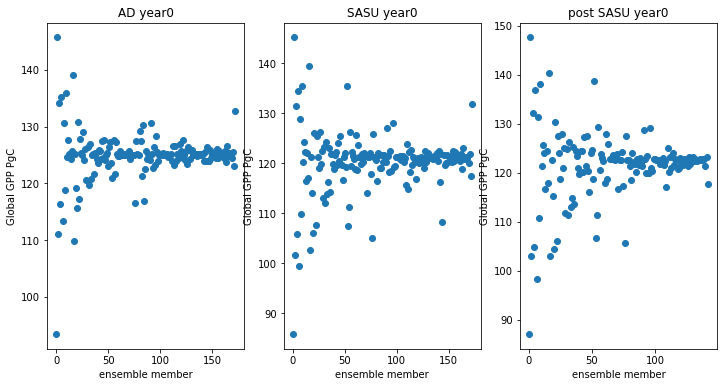

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(range(len(gpp_AD.ens)),gpp_AD.isel(year=0))
plt.title("AD year0")
plt.xlabel('ensemble member')
plt.ylabel('Global GPP PgC')

plt.subplot(1,3,2)
plt.scatter(range(len(gpp_SASU.ens)),gpp_SASU.isel(year=0))
plt.title("SASU year0")
plt.xlabel('ensemble member')
plt.ylabel('Global GPP PgC')

plt.subplot(1,3,3)
plt.scatter(range(len(gpp_pSASU.ens)),gpp_pSASU.isel(year=0))
plt.title("post SASU year0")
plt.xlabel('ensemble member')
plt.ylabel('Global GPP PgC')

In [94]:
cf=1e-9*la.sum()
tvc_AD=cf*gmean(dsets['AD'].TOTVEGC,la)
tvc_SASU=cf*gmean(dsets['SASU'].TOTVEGC,la)
tvc_pSASU=cf*gmean(dsets['postSASU'].TOTVEGC,la)

Text(0, 0.5, 'TOTVEGC postSASU year0')

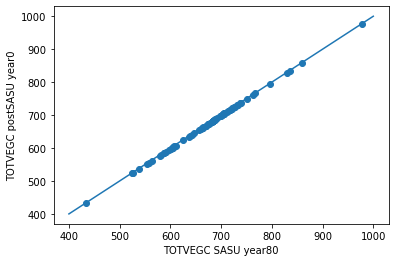

In [108]:
plt.scatter(tvc_SASU.isel(year=79,ens=slice(0,80)),tvc_pSASU.isel(year=1,ens=slice(0,80)))
plt.plot([400,1000],[400,1000])
plt.xlabel('TOTVEGC SASU year80')
plt.ylabel('TOTVEGC postSASU year0')

Text(0, 0.5, 'Global TOTVEGC PgC')

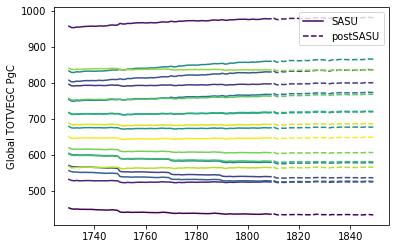

In [100]:
cmap = cm.get_cmap('viridis', 20) 
for i in range(20):
    if i==0:
        plt.plot(tvc_SASU.year,tvc_SASU.isel(ens=i),c=cmap(i),label='SASU')
        plt.plot(tvc_pSASU.year,tvc_pSASU.isel(ens=i),c=cmap(i),linestyle='--',label='postSASU')
    else:
        plt.plot(tvc_SASU.year,tvc_SASU.isel(ens=i),c=cmap(i))
        plt.plot(tvc_pSASU.year,tvc_pSASU.isel(ens=i),c=cmap(i),linestyle='--')
plt.legend()
plt.ylabel('Global TOTVEGC PgC')

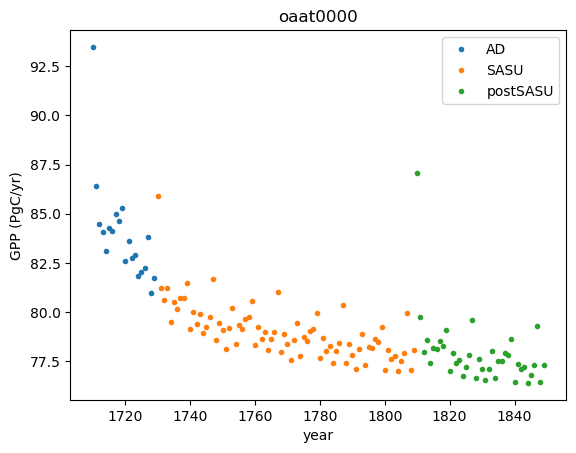

In [25]:
cf=24*60*60*365*1e-9*la.sum()
k='oaat0000'
for case in dsets:
    gpp=cf*gmean(dsets[case].GPP.sel(ens=k),la)
    gpp.plot.line('.',label=case)
plt.legend()
plt.title(k)
plt.ylabel('GPP (PgC/yr)');

In [64]:
gpp=xr.concat([24*60*60*365*dsets[c].GPP for c in cases],dim='year')

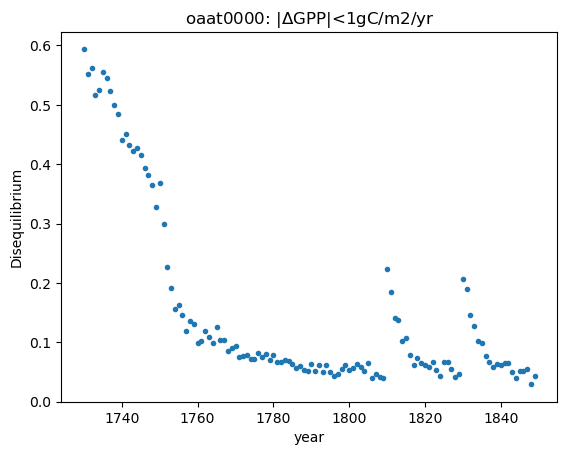

In [98]:
k='oaat0000'
dx=abs(gpp-gpp.shift(year=20))
diseq=(la*(dx>20)).sum(dim='gridcell').where(gpp.year>=1730)/la.sum()
diseq.sel(ens=k).plot.line('.')
plt.ylim(bottom=0)
plt.ylabel('Disequilibrium')
plt.title(k+': |$\Delta$GPP|<1gC/m2/yr');

In [116]:
cf=1e-9*la.sum()
tec=cf*gmean(dsets['postSASU'].TOTECOSYSC,la)

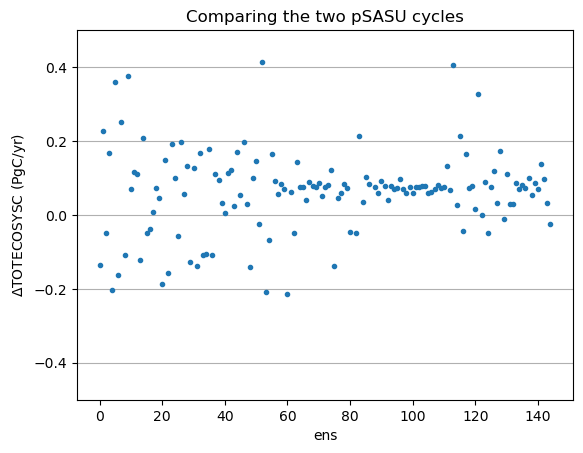

In [136]:
ees=[int(ee[4:]) for ee in tec.ens.values]
dtec=(tec-tec.shift(year=20)).isel(year=range(20,40)).mean(dim='year')/20
plt.plot(ees,dtec,'.')
plt.xlabel('ens')
plt.ylabel('$\Delta$TOTECOSYSC (PgC/yr)')
plt.ylim([-0.5,0.5])
plt.grid(axis='y')
plt.title('Comparing the two pSASU cycles');
plt.savefig('dtec_drift.png',dpi=300,bbox_inches='tight')

### First Month

In [40]:
cases=['postSASU']
dsets={c:get_case(c,inits,monthly) for c in cases}

In [48]:
cf=24*60*60*365*1e-9*la.sum()
gpp = cf*gmean(dsets[]['GPP'].isel(time=1),la)

In [52]:
cf = 1e-9*la.sum()
totveg = cf*gmean(dsets['postSASU']['TOTECOSYSC'].isel(time=1),la)

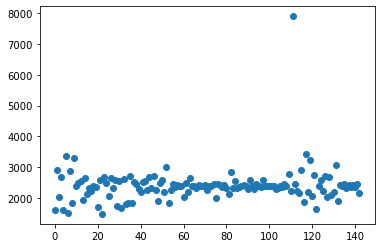

In [53]:
plt.scatter(range(len(gpp.ens)),totveg)

### AD first year

In [75]:
cases=['AD','SASU']
dsets={c:get_case(c,inits,monthly) for c in cases}

AD oaat0081 1 files
AD oaat0087 1 files
SASU oaat0081 0 files
SASU oaat0087 0 files


In [76]:
map = get_map(dsets['SASU'].isel(ens=0,year=0))

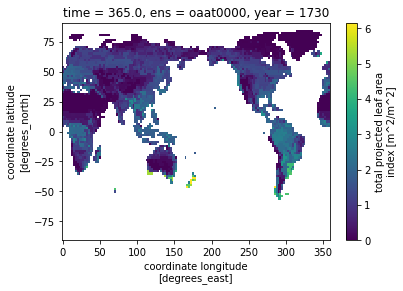

In [77]:
map.TLAI.plot()

In [78]:
cf=24*60*60*365*1e-9*la.sum()
gpp_ad = cf*gmean(dsets['AD'].GPP.isel(year=0),la)
gpp_sasu = cf*gmean(dsets['SASU'].GPP.isel(year=0),la)

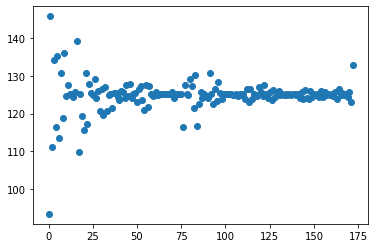

In [74]:
plt.scatter(range(len(gpp_ad.ens)),gpp_ad)

In [79]:
diff = gpp_ad - gpp_sasu

In [80]:
diff

<xarray.DataArray (ens: 173)>
array([ 7.56859894,  0.52722512,  9.30759858,  2.80207424, 10.48273438,
        0.72804212, 13.9091901 ,  1.89993585,  8.86875092,  0.34416562,
        4.47318335,  3.36780191,  2.77598871,  8.34676795,  2.20156891,
        8.4941738 , -0.32131855,  7.17251873,  3.87530089,  5.16719895,
        9.62878195,  4.58894566,  9.52450222,  2.43894387,  4.04889864,
        5.8912752 ,  2.90454706,  4.18483132,  3.52048029,  7.65140691,
        3.1809286 ,  7.65234559,  2.7380263 ,  6.89216671,  8.73972927,
        2.0272096 ,  7.3199561 ,  3.46598352,  3.47647065,  4.38842338,
        4.72698784,  4.32171057,  3.44437768,  4.61100848,  3.44287332,
        4.14677287,  2.24778701,  4.45744204,  8.40968551,  4.09942463,
        1.13632242,  6.99575877, -8.1688616 , 15.95176832,  9.57775762,
        1.31749122,  2.24078682,  4.985571  ,  3.63038856,  3.89901535,
        5.9277007 ,  0.09678496,  6.25312746,  1.53845141,  3.8477748 ,
        3.85377816,  5.18970941,  3.15157926,  4.72712349,  3.00745565,
        4.23954411, 10.13424552,  3.85431866,  3.76101114,  2.89214294,
        7.22578864, 11.40354555,  1.53137144,  3.88071591,  3.81725117,
        8.57242219, 10.86068864, -0.73772363,  8.60235965, -2.33570297,
        3.40172249,  4.05208698,  3.95409146,  3.5096042 ,  4.04783366,
        3.72114308,  3.40855998,  3.81718673,  4.36328956,  3.86235182,
        4.88307532,  0.35607161,  6.22570319,  4.37270156,  3.85463912,
        3.85463912,  3.91311388,  4.0222516 ,  3.7789041 ,  4.21814458,
        4.11101877,  3.64218128,  4.47460097,  4.00614433,  9.16176245,
        1.22382635,  9.03435468,  4.16022322,  4.8154954 ,  4.01209457,
        4.34008741,  3.76289687,  3.8570731 ,  4.18901518, 10.01125397,
        4.61824995,  4.59123795,  7.32044365,  3.85463912,  3.98495386,
        4.48584608,  4.34031565,  3.86927273,  3.98710172,  3.98373511,
        3.85129821,  3.8722862 ,  3.83687924,  3.77350927,  3.83522298,
        4.09176144,  3.613296  ,  3.98218955,  3.7603381 ,  3.19691025,
        4.48012224,  2.82686362,  7.80847676,  3.76476882, 15.55095977,
        4.58079795,  4.28285759,  3.74900299,  4.17439765,  4.16521008,
        3.80436536,  4.00107348,  3.79499751,  4.22123505,  3.49360734,
        3.94466791,  3.52121597,  3.86653615,  3.89322238,  3.78440878,
        3.83459167,  4.06445675,  3.87053633,  4.81652986,  3.54691608,
        3.85612922,  4.60927013,  3.72941368,  3.9737768 ,  4.41704033,
        3.68743015,  5.53902451,  0.96618328])
Coordinates:
    time     float64 365.0
  * ens      (ens) <U8 'oaat0000' 'oaat0001' ... 'oaat0173' 'oaat0174'

### Check maps

In [83]:
#lai_AD=get_map(dsets['AD']['TLAI'].isel(ens=100,year=0))
lai_SASU=get_map(dsets['SASU']['TLAI'].isel(ens=100,year=79))
lai_pSASU=get_map(dsets['postSASU']['TLAI'].isel(ens=100,year=0))

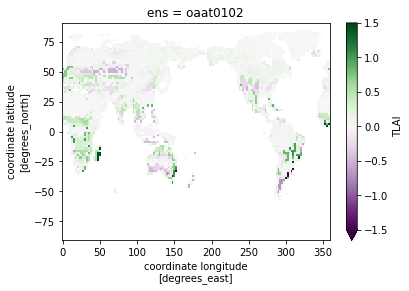

In [91]:
(lai_pSASU-lai_SASU).plot(cmap='PRGn',vmin=-1.5,vmax=1.5)

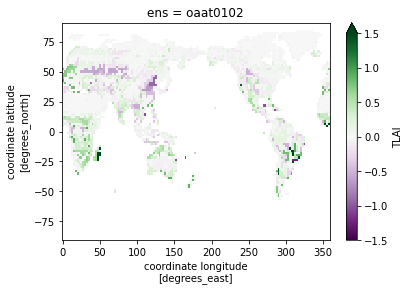

In [93]:
a = get_map(dsets['postSASU']['TLAI'].isel(ens=100,year=13))
b = get_map(dsets['postSASU']['TLAI'].isel(ens=100,year=0))
(b-a).plot(cmap='PRGn',vmin=-1.5,vmax=1.5)

### older stuff

In [2]:

def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    xa.attrs=da.attrs
    return xa

def gmean(da,la):
    x=1/la.sum()*(da*la).sum(dim='gridcell')
    x.name=da.name
    x.attrs=da.attrs
    return x

In [3]:
dvs=['TOTVEGC','TOTSOMC_1m','TLAI','GPP']
def pp0(ds):
    out=xr.Dataset({dv:gmean(ds[dv],la) for dv in dvs})
    return out
    
    
def pp1(ds):
    yr0=ds['time.year'].values[0]
    ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')
    out=xr.Dataset({dv:gmean(amean(ds[dv]),la) for dv in dvs})
    return out

### evaluate spinup

In [4]:
k='LHC0021'
datadirs={'SASU':'/glade/scratch/djk2120/PPEn11_transient_SASU_'+k+'/run/',
          'postSASU':'/glade/scratch/djk2120/PPEn11_transient_postSASU_'+k+'/run/',
          'historical':'/glade/scratch/djk2120/PPEn11_transient_'+k+'/run/',
          'SSP3-7':'/glade/scratch/djk2120/PPEn11_transient_SSP370_'+k+'/run/'}
pp={'SASU':pp0,
    'postSASU':pp0,
    'historical':pp1,
    'SSP3-7':pp1}

In [5]:
dsets={}
yr0=1730
for s in datadirs:
    if s=='SSP3-7':
        files=sorted(glob.glob(datadirs[s]+'*.h0.*'))[:2]
    else:
        files=sorted(glob.glob(datadirs[s]+'*.h0.*'))
    ds=xr.open_mfdataset(files,combine='by_coords',preprocess=pp[s])
    if 'SASU' in s:
        ds=ds.isel(time=np.arange(len(ds.time))>0)
        ds['time']=range(yr0,yr0+len(ds.time))
        yr0=yr0+len(ds.time)
    dsets[s]=ds

In [32]:
dxs=[]
for i in range(500):
    k='LHC'+str(i).zfill(4)
    d='/glade/scratch/djk2120/PPEn11_transient_postSASU_'+k+'/run/'
    files=sorted(glob.glob(d+'*.clm2.h0.*'))
    ds=xr.open_mfdataset(files,combine='by_coords',preprocess=pp0)
    dx=1e-9*24*60*60*365/10*la.sum()*abs(ds.GPP[1:21].mean()-ds.GPP[21:].mean())
    if i%50==0:
        print(k,dx.values)
    dxs.append(dx)

LHC0000 0.006655631316664795
LHC0050 0.00359558413597826
LHC0100 0.006337735605190233


OSError: no files to open

(array([44., 24., 16.,  9.,  6.,  5.,  3.,  2.,  1.,  1.]),
 array([0.00059438, 0.0120256 , 0.02345681, 0.03488802, 0.04631924,
        0.05775045, 0.06918166, 0.08061288, 0.09204409, 0.1034753 ,
        0.11490652]),
 <BarContainer object of 10 artists>)

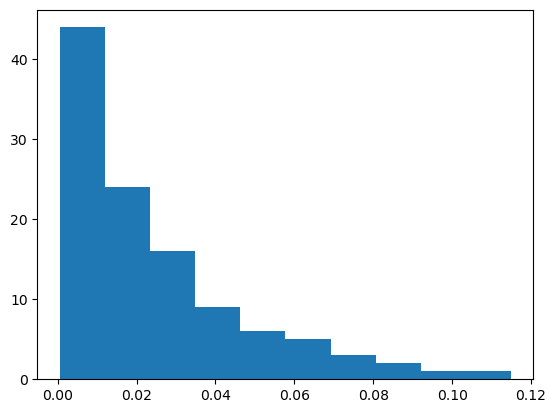

In [33]:
plt.hist(dxs)

Text(0, 0.5, 'GPP (PgC/yr)')

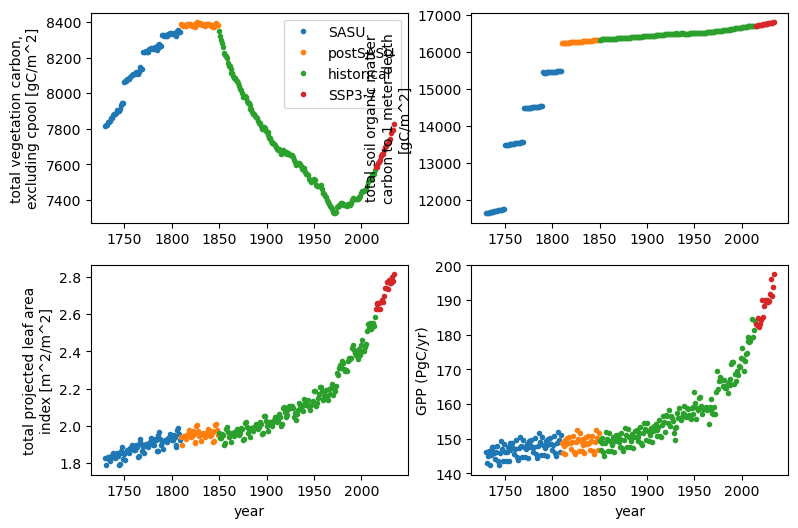

In [6]:
plt.figure(figsize=[9,6])

for i,dv in enumerate(dvs[:3]):
    plt.subplot(2,2,i+1)
    for s in dsets:
        dsets[s][dv].plot.line('.',label=s)
    if i<2:
        plt.xlabel('')
    if i==0:
        plt.legend()
        
plt.subplot(2,2,4) 
cf=1e-9*24*60*60*365*la.sum()
v='GPP'
for s in dsets:
    (cf*dsets[s][v]).plot.line('.',label=s)
plt.ylabel('GPP (PgC/yr)')


#plt.subplots_adjust(wspace=0.4)
#plt.savefig('../figs/spinup/lhc0001_test.png',dpi=300,bbox_inches='tight')

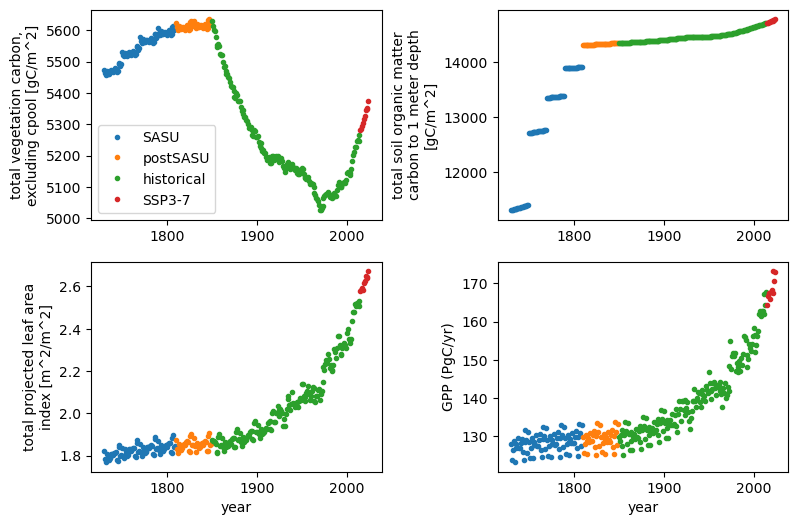

In [6]:
plt.figure(figsize=[9,6])
dvs=['TOTVEGC','TOTSOMC_1m','TLAI']
for i,dv in enumerate(dvs):
    plt.subplot(2,2,i+1)
    for s in dsets:
        dsets[s][dv].plot.line('.',label=s)
    if i<2:
        plt.xlabel('')
    if i==0:
        plt.legend()
        
plt.subplot(2,2,4) 
cf=1e-9*24*60*60*365*la.sum()
v='GPP'
for s in dsets:
    (cf*dsets[s][v]).plot.line('.',label=s)
plt.ylabel('GPP (PgC/yr)')


plt.subplots_adjust(wspace=0.4)
plt.savefig('../figs/spinup/lhc0001_test.png',dpi=300,bbox_inches='tight')

(2000.0, 2020.0)

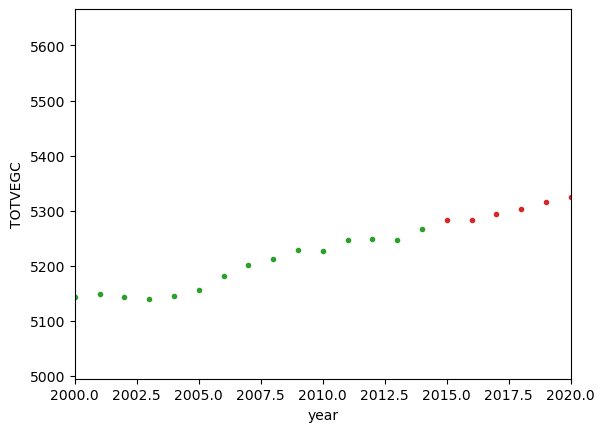

In [9]:
cf=1
v='TOTVEGC'
for s in dsets:
    (cf*dsets[s][v]).plot.line('.',label=s)
plt.xlim([2000,2020])

